# Problem 2: Bayes Classifier using Gaussian Mixture Models (GMM)

In this notebook, we'll implement a Bayes classifier using Gaussian Mixture Models (GMM) for three different datasets:

1. **Linearly separable classes**: 3 classes with 2D linearly separable data (500 points per class)
2. **Nonlinearly separable classes**: 2D data with 2 or 3 classes that are nonlinearly separable
3. **Real-world data (Vowel data)**: 2D data with 3 classes representing formant frequencies F1 and F2 for vowel utterances

We'll experiment with different numbers of mixtures for the GMM (1, 2, 4, 8, 16, 32, 64) and evaluate each model's performance.

## Import Required Libraries

In [49]:
import numpy as np
np.bool = bool  # add deprecated alias for numpy.bool
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from scipy.stats import multivariate_normal
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.mixture import GaussianMixture
import warnings
warnings.filterwarnings('ignore')
import re  # for parsing counts from header

# Set random seed for reproducibility
np.random.seed(42)

## Helper Functions for Data Loading and Preprocessing

In [50]:
def load_linearly_separable_data():
    """Load the linearly separable dataset (Dataset 1)"""
    data_folder = "Datasets Assignment 3/LS_Group12/"
    class_data = []
    class_labels = []
    
    for i in range(1, 4):  # 3 classes
        file_path = f"{data_folder}Class{i}.txt"
        data = np.loadtxt(file_path)
        class_data.append(data)
        class_labels.append(np.full(len(data), i-1))
    
    X = np.vstack(class_data)
    y = np.concatenate(class_labels)
    
    return X, y

def load_nonlinearly_separable_data():
    """Load the nonlinearly separable dataset (Dataset 2)"""
    file_path = "Datasets Assignment 3/NLS_Group12.txt"
    # Read header line and extract sample counts per class
    with open(file_path, 'r') as f:
        header = f.readline().strip()
    # Extract only the three class sizes (e.g. '500 examples')
    counts = list(map(int, re.findall(r'(\d+)\s+examples', header)))
    # Load data skipping header
    data = np.loadtxt(file_path, skiprows=1)
    X = data[:, :2]
    # Build labels: first count[0] -> class0, next count[1] -> class1, etc.
    y = np.concatenate([np.full(n, i) for i, n in enumerate(counts)])
    return X, y

def load_real_world_data():
    """Load the real world vowel dataset (Dataset 3)"""
    data_folder = "Datasets Assignment 3/rd_group12/"
    class_data = []
    class_labels = []
    
    for i in range(1, 4):  # 3 classes
        file_path = f"{data_folder}class{i}.txt"
        data = np.loadtxt(file_path)
        class_data.append(data)
        class_labels.append(np.full(len(data), i-1))
    
    X = np.vstack(class_data)
    y = np.concatenate(class_labels)
    
    return X, y

def split_data(X, y, test_size=0.3):
    """Split data into training and test sets with stratification"""
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42, stratify=y)
    return X_train, X_test, y_train, y_test

## Gaussian Mixture Model Implementation

In [51]:
class BayesGMM:
    """Bayes Classifier with Gaussian Mixture Model class conditionals"""
    
    def __init__(self, n_components_list=[1, 2, 4, 8, 16, 32, 64]):
        """Initialize the classifier with different numbers of GMM components"""
        self.n_components_list = n_components_list
        self.models = {}
        self.priors = {}
        self.classes = None
        self.best_n_components = None
        self.component_log_likelihood = {}
        
    def fit(self, X_train, y_train):
        """Fit GMMs for each class using different numbers of components"""
        self.classes = np.unique(y_train)
        self.models = {n_comp: {} for n_comp in self.n_components_list}
        self.priors = {}
        self.component_log_likelihood = {n_comp: {} for n_comp in self.n_components_list}
        
        # Calculate class priors
        for c in self.classes:
            self.priors[c] = np.mean(y_train == c)
        
        # Fit GMM for each class and for each number of components
        for n_components in self.n_components_list:
            for c in self.classes:
                X_class = X_train[y_train == c]
                
                # Initialize with K-means
                kmeans = KMeans(n_clusters=n_components, random_state=42).fit(X_class)
                initial_means = kmeans.cluster_centers_
                
                # Fit GMM
                gmm = GaussianMixture(
                    n_components=n_components,
                    covariance_type='full',
                    means_init=initial_means,
                    random_state=42,
                    max_iter=100,
                    verbose=0
                )
                
                gmm.fit(X_class)
                self.models[n_components][c] = gmm
                self.component_log_likelihood[n_components][c] = gmm.score_samples(X_class)
                
        return self
    
    def predict_proba(self, X, n_components):
        """Calculate posterior probabilities for each class"""
        probs = np.zeros((X.shape[0], len(self.classes)))
        
        for i, c in enumerate(self.classes):
            # Calculate class-conditional density times prior
            gmm = self.models[n_components][c]
            probs[:, i] = np.exp(gmm.score_samples(X)) * self.priors[c]
            
        # Normalize to get posterior probabilities
        probs_sum = probs.sum(axis=1, keepdims=True)
        probs_sum[probs_sum == 0] = 1  # Avoid division by zero
        probs = probs / probs_sum
        
        return probs
    
    def predict(self, X, n_components):
        """Predict class labels using Bayes rule"""
        probs = self.predict_proba(X, n_components)
        return self.classes[np.argmax(probs, axis=1)]
    
    def evaluate(self, X_test, y_test):
        """Evaluate the model for all component counts and find the best one"""
        results = {}
        best_accuracy = 0
        best_n_components = self.n_components_list[0]
        
        for n_components in self.n_components_list:
            y_pred = self.predict(X_test, n_components)
            
            # Calculate metrics
            accuracy = accuracy_score(y_test, y_pred)
            precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average=None)
            mean_precision = np.mean(precision)
            mean_recall = np.mean(recall)
            mean_f1 = np.mean(f1)
            conf_matrix = confusion_matrix(y_test, y_pred)
            
            # Store results
            results[n_components] = {
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'f1': f1,
                'mean_precision': mean_precision,
                'mean_recall': mean_recall,
                'mean_f1': mean_f1,
                'confusion_matrix': conf_matrix
            }
            
            # Update best model
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_n_components = n_components
        
        self.best_n_components = best_n_components
        return results

## Visualization Functions

In [52]:
def plot_density_contours(X, y, model, n_components, dataset_name):
    """Plot constant density contours for all classes with training data"""
    classes = np.unique(y)
    colors = ['blue', 'red', 'green']
    plt.figure(figsize=(12, 10))
    
    # Create a grid for contour plotting
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                         np.linspace(y_min, y_max, 500))
    grid = np.c_[xx.ravel(), yy.ravel()]
    
    for idx, c in enumerate(classes):
        # Plot training points for this class
        plt.scatter(X[y == c, 0], X[y == c, 1], color=colors[idx], alpha=0.5, label=f'Class {c}')
        
        # Get the GMM for this class
        gmm = model.models[n_components][c]
        
        # Calculate log-density on the grid
        log_density = gmm.score_samples(grid).reshape(xx.shape)
        
        # Plot density contours
        levels = np.linspace(log_density.min(), log_density.max(), 10)[1:-1]
        plt.contour(xx, yy, log_density, levels=levels, colors=colors[idx], alpha=0.7)
        
    plt.title(f'GMM Density Contours ({n_components} components) - {dataset_name}')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_decision_regions(X, y, model, n_components, dataset_name):
    """Plot decision regions with training data superposed"""
    plt.figure(figsize=(10, 8))
    
    # Create a mesh grid for decision boundaries with fixed resolution
    grid_size = 200
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, grid_size),
        np.linspace(y_min, y_max, grid_size)
    )
    
    # Predict the class for each point in the mesh grid
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()], n_components)
    Z = Z.reshape(xx.shape)
    
    # Create a custom colormap
    cmap_light = ListedColormap(['#AAAAFF', '#FFAAAA', '#AAFFAA'])
    cmap_bold = ListedColormap(['#0000FF', '#FF0000', '#00FF00'])
    
    # Plot the decision boundary
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light, alpha=0.3)
    
    # Plot the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold, edgecolors='k', s=50, alpha=0.7)
    
    plt.title(f'Decision Regions - GMM ({n_components} components) - {dataset_name}')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.tight_layout()
    plt.show()

def plot_log_likelihood(model, dataset_name):
    """Plot iterations vs log likelihood for different numbers of components"""
    plt.figure(figsize=(14, 10))
    
    for n_comp in model.n_components_list:
        # Average log-likelihood across classes
        avg_ll = np.mean([model.component_log_likelihood[n_comp][c].mean() for c in model.classes])
        plt.scatter(n_comp, avg_ll, s=100)
        
    plt.plot(model.n_components_list, 
             [np.mean([model.component_log_likelihood[n_comp][c].mean() for c in model.classes]) for n_comp in model.n_components_list],
             '-o')
    plt.title(f'Log Likelihood vs Number of Components - {dataset_name}')
    plt.xlabel('Number of Components')
    plt.ylabel('Average Log Likelihood')
    plt.xscale('log', base=2)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def display_metrics(results, n_components, classes):
    """Display classification metrics for a specific number of components"""
    metrics = results[n_components]
    print(f"\nMetrics for GMM with {n_components} components:")
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    
    # Per-class metrics
    for i, c in enumerate(classes):
        print(f"Class {c}:")
        print(f"  Precision: {metrics['precision'][i]:.4f}")
        print(f"  Recall: {metrics['recall'][i]:.4f}")
        print(f"  F1 Score: {metrics['f1'][i]:.4f}")
    
    # Mean metrics
    print("\nMean metrics:")
    print(f"  Precision: {metrics['mean_precision']:.4f}")
    print(f"  Recall: {metrics['mean_recall']:.4f}")
    print(f"  F1 Score: {metrics['mean_f1']:.4f}")

def plot_confusion_matrix(results, n_components, classes):
    """Plot confusion matrix for a specific number of components"""
    conf_matrix = results[n_components]['confusion_matrix']
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=[f'Class {c}' for c in classes],
                yticklabels=[f'Class {c}' for c in classes])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - GMM ({n_components} components)')
    plt.tight_layout()
    plt.show()

## Experiment 1: Linearly Separable Dataset

In [53]:
# Load the linearly separable dataset
X_ls, y_ls = load_linearly_separable_data()
X_train_ls, X_test_ls, y_train_ls, y_test_ls = split_data(X_ls, y_ls)

print(f"Dataset 1 (Linearly Separable):")
print(f"Total samples: {len(X_ls)}")
print(f"Training samples: {len(X_train_ls)}")
print(f"Testing samples: {len(X_test_ls)}")
print(f"Unique classes: {np.unique(y_ls)}")
print(f"Class distribution: {[np.sum(y_ls == c) for c in np.unique(y_ls)]}")

Dataset 1 (Linearly Separable):
Total samples: 1500
Training samples: 1050
Testing samples: 450
Unique classes: [0 1 2]
Class distribution: [500, 500, 500]


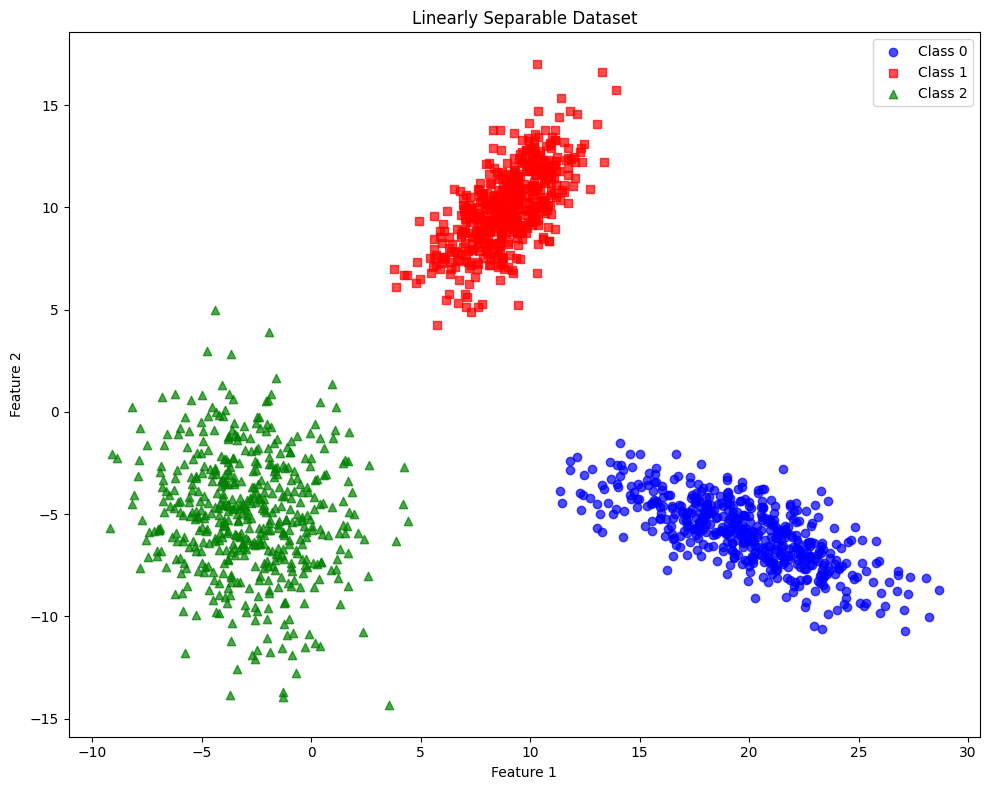

In [54]:
# Visualize the data
plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green']
markers = ['o', 's', '^']

for i, c in enumerate(np.unique(y_ls)):
    plt.scatter(X_ls[y_ls == c, 0], X_ls[y_ls == c, 1], 
                color=colors[i], marker=markers[i], label=f'Class {c}', alpha=0.7)
plt.legend()
plt.title('Linearly Separable Dataset')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.tight_layout()
plt.show()

In [55]:
# Train and evaluate the Bayes GMM classifier on the linearly separable dataset
gmm_ls = BayesGMM()
gmm_ls.fit(X_train_ls, y_train_ls)
results_ls = gmm_ls.evaluate(X_test_ls, y_test_ls)

In [56]:
# Display results for the linearly separable dataset
print("Results for Linearly Separable Dataset:")
for n_comp in gmm_ls.n_components_list:
    print(f"\n{n_comp} components - Accuracy: {results_ls[n_comp]['accuracy']:.4f}")

Results for Linearly Separable Dataset:

1 components - Accuracy: 1.0000

2 components - Accuracy: 1.0000

4 components - Accuracy: 1.0000

8 components - Accuracy: 1.0000

16 components - Accuracy: 1.0000

32 components - Accuracy: 1.0000

64 components - Accuracy: 1.0000



Best number of components for linearly separable dataset: 1

Metrics for GMM with 1 components:
Accuracy: 1.0000
Class 0:
  Precision: 1.0000
  Recall: 1.0000
  F1 Score: 1.0000
Class 1:
  Precision: 1.0000
  Recall: 1.0000
  F1 Score: 1.0000
Class 2:
  Precision: 1.0000
  Recall: 1.0000
  F1 Score: 1.0000

Mean metrics:
  Precision: 1.0000
  Recall: 1.0000
  F1 Score: 1.0000


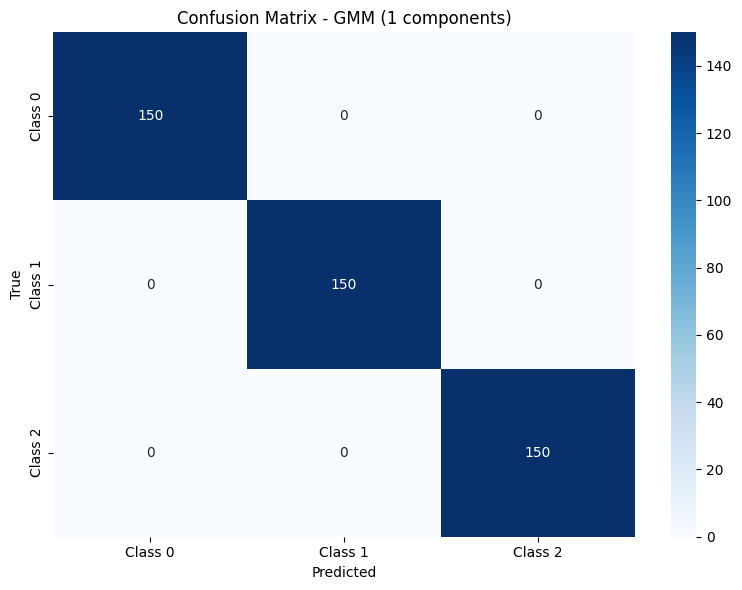

In [57]:
# Show detailed metrics for the best model on linearly separable dataset
best_n_comp_ls = gmm_ls.best_n_components
print(f"\nBest number of components for linearly separable dataset: {best_n_comp_ls}")
display_metrics(results_ls, best_n_comp_ls, np.unique(y_ls))
plot_confusion_matrix(results_ls, best_n_comp_ls, np.unique(y_ls))

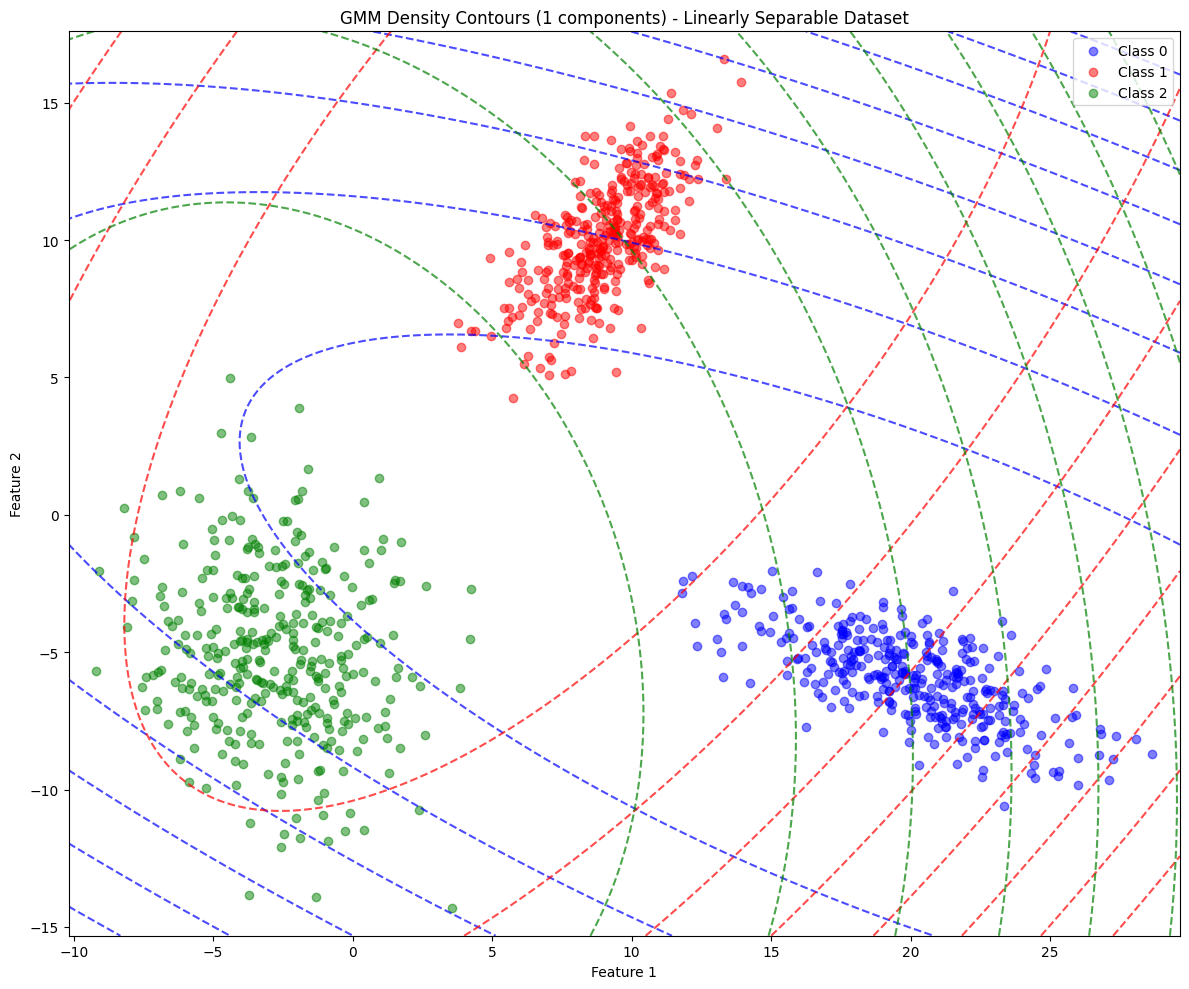

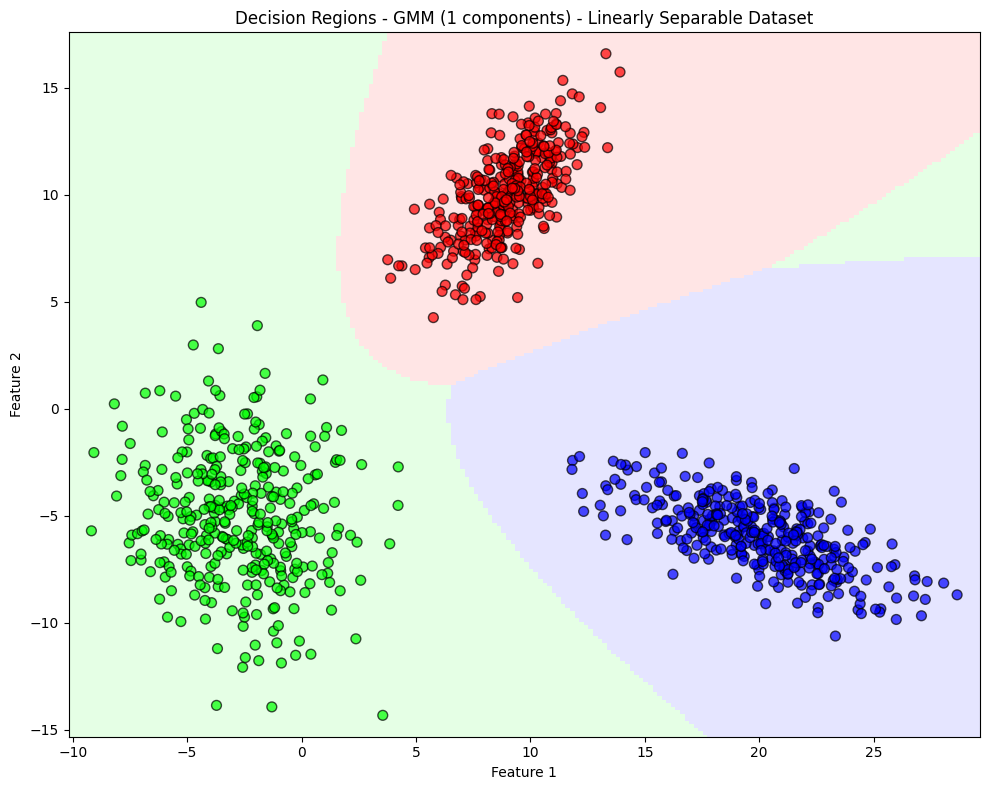

In [58]:
# Plot density contours and decision regions for the best model
plot_density_contours(X_train_ls, y_train_ls, gmm_ls, best_n_comp_ls, "Linearly Separable Dataset")
plot_decision_regions(X_train_ls, y_train_ls, gmm_ls, best_n_comp_ls, "Linearly Separable Dataset")

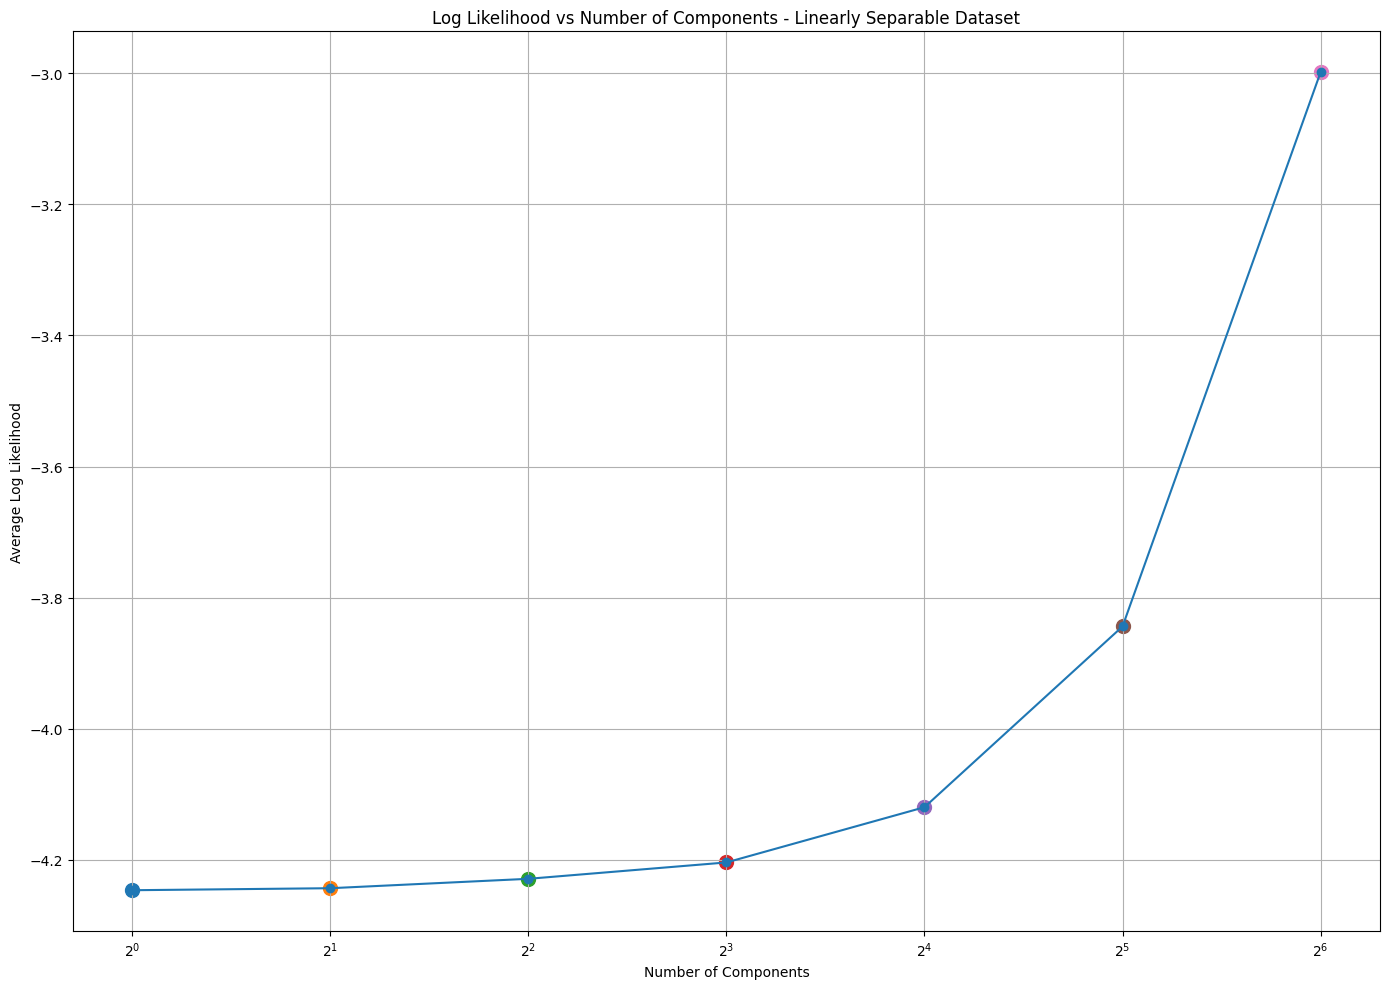

In [59]:
# Plot log likelihood vs number of components
plot_log_likelihood(gmm_ls, "Linearly Separable Dataset")

## Experiment 2: Nonlinearly Separable Dataset

In [60]:
# Load the nonlinearly separable dataset
X_nls, y_nls = load_nonlinearly_separable_data()
X_train_nls, X_test_nls, y_train_nls, y_test_nls = split_data(X_nls, y_nls)

print(f"Dataset 2 (Nonlinearly Separable):")
print(f"Total samples: {len(X_nls)}")
print(f"Training samples: {len(X_train_nls)}")
print(f"Testing samples: {len(X_test_nls)}")
print(f"Unique classes: {np.unique(y_nls)}")
print(f"Class distribution: {[np.sum(y_nls == c) for c in np.unique(y_nls)]}")

Dataset 2 (Nonlinearly Separable):
Total samples: 1500
Training samples: 1050
Testing samples: 450
Unique classes: [0 1 2]
Class distribution: [500, 500, 500]


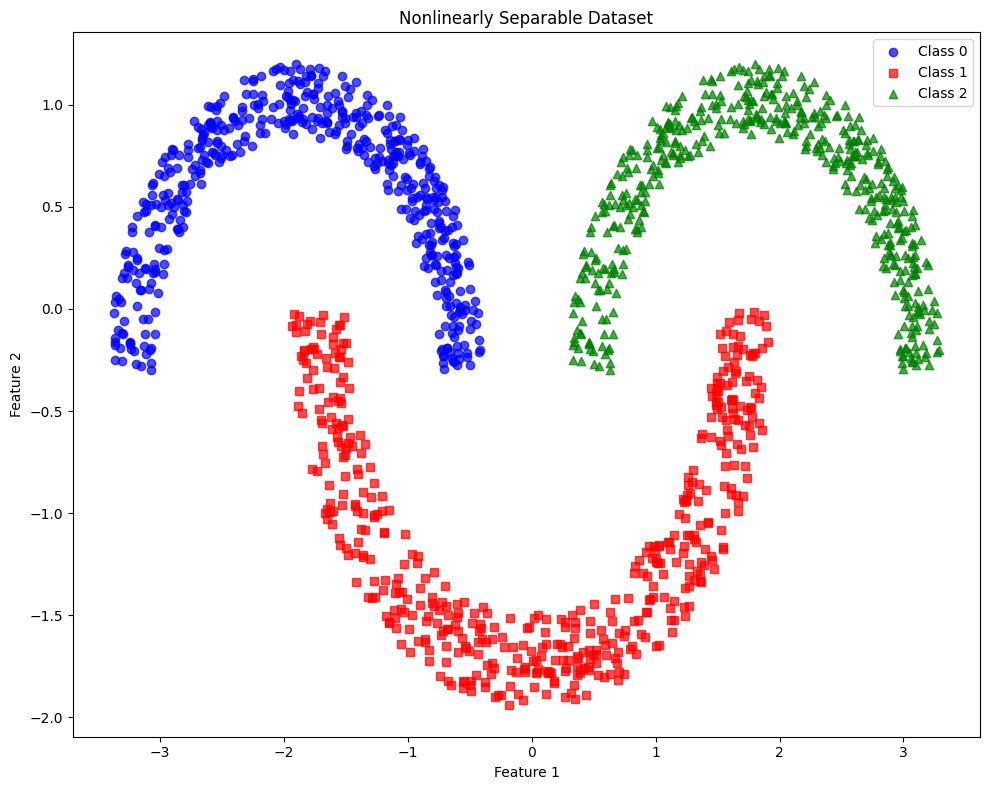

In [61]:
# Visualize the data
plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green']
markers = ['o', 's', '^']

for i, c in enumerate(np.unique(y_nls)):
    plt.scatter(X_nls[y_nls == c, 0], X_nls[y_nls == c, 1], 
                color=colors[i], marker=markers[i], label=f'Class {c}', alpha=0.7)
plt.legend()
plt.title('Nonlinearly Separable Dataset')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.tight_layout()
plt.show()

In [62]:
# Train and evaluate the Bayes GMM classifier on the nonlinearly separable dataset
gmm_nls = BayesGMM()
gmm_nls.fit(X_train_nls, y_train_nls)
results_nls = gmm_nls.evaluate(X_test_nls, y_test_nls)

In [63]:
# Display results for the nonlinearly separable dataset
print("Results for Nonlinearly Separable Dataset:")
for n_comp in gmm_nls.n_components_list:
    print(f"\n{n_comp} components - Accuracy: {results_nls[n_comp]['accuracy']:.4f}")

Results for Nonlinearly Separable Dataset:

1 components - Accuracy: 0.9378

2 components - Accuracy: 1.0000

4 components - Accuracy: 1.0000

8 components - Accuracy: 1.0000

16 components - Accuracy: 1.0000

32 components - Accuracy: 1.0000

64 components - Accuracy: 1.0000



Best number of components for nonlinearly separable dataset: 2

Metrics for GMM with 2 components:
Accuracy: 1.0000
Class 0:
  Precision: 1.0000
  Recall: 1.0000
  F1 Score: 1.0000
Class 1:
  Precision: 1.0000
  Recall: 1.0000
  F1 Score: 1.0000
Class 2:
  Precision: 1.0000
  Recall: 1.0000
  F1 Score: 1.0000

Mean metrics:
  Precision: 1.0000
  Recall: 1.0000
  F1 Score: 1.0000


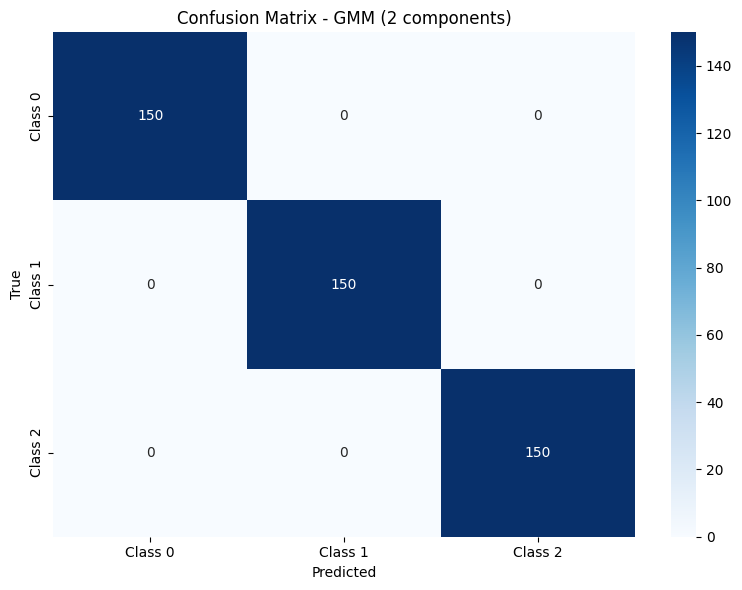

In [64]:
# Show detailed metrics for the best model on nonlinearly separable dataset
best_n_comp_nls = gmm_nls.best_n_components
print(f"\nBest number of components for nonlinearly separable dataset: {best_n_comp_nls}")
display_metrics(results_nls, best_n_comp_nls, np.unique(y_nls))
plot_confusion_matrix(results_nls, best_n_comp_nls, np.unique(y_nls))

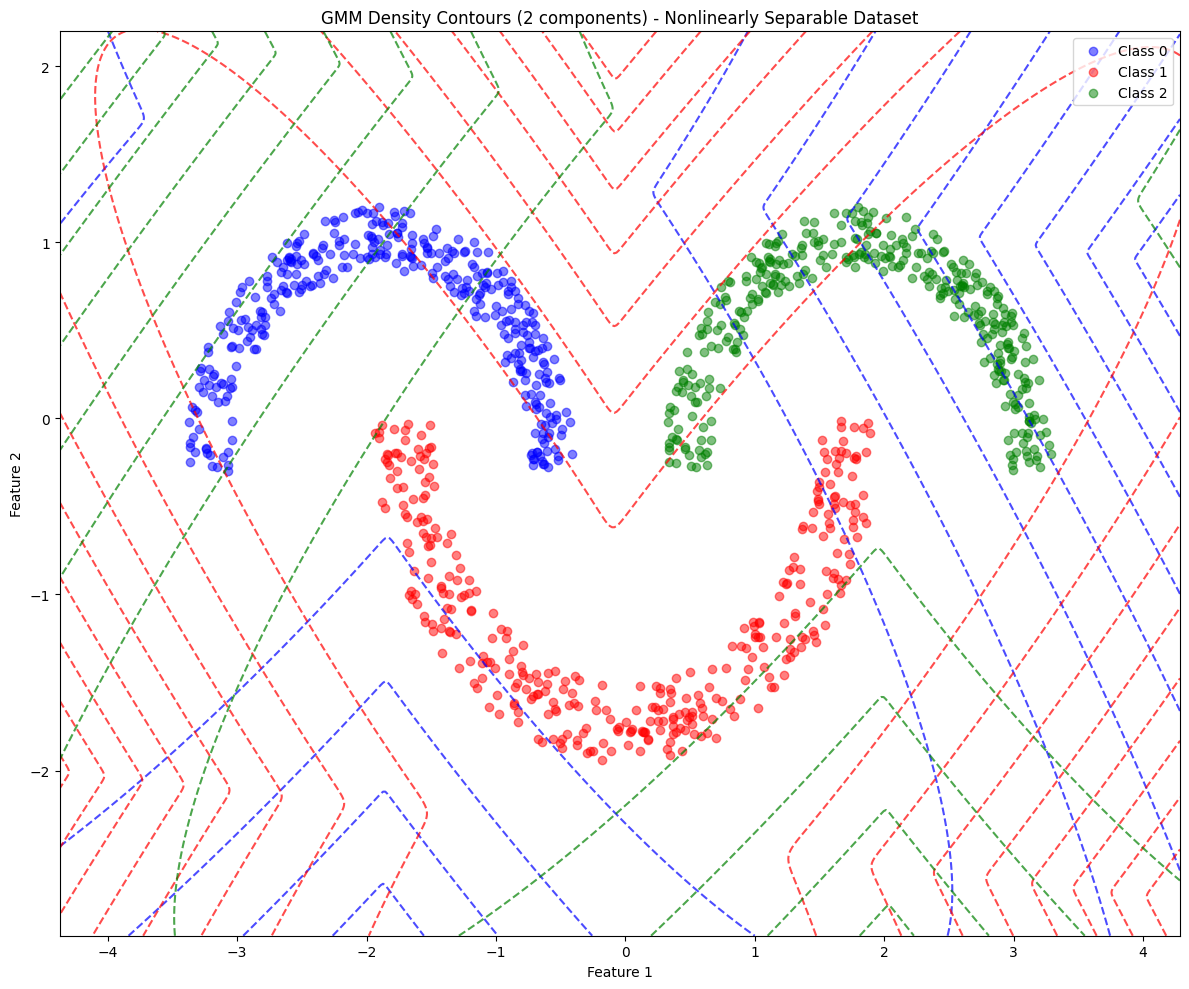

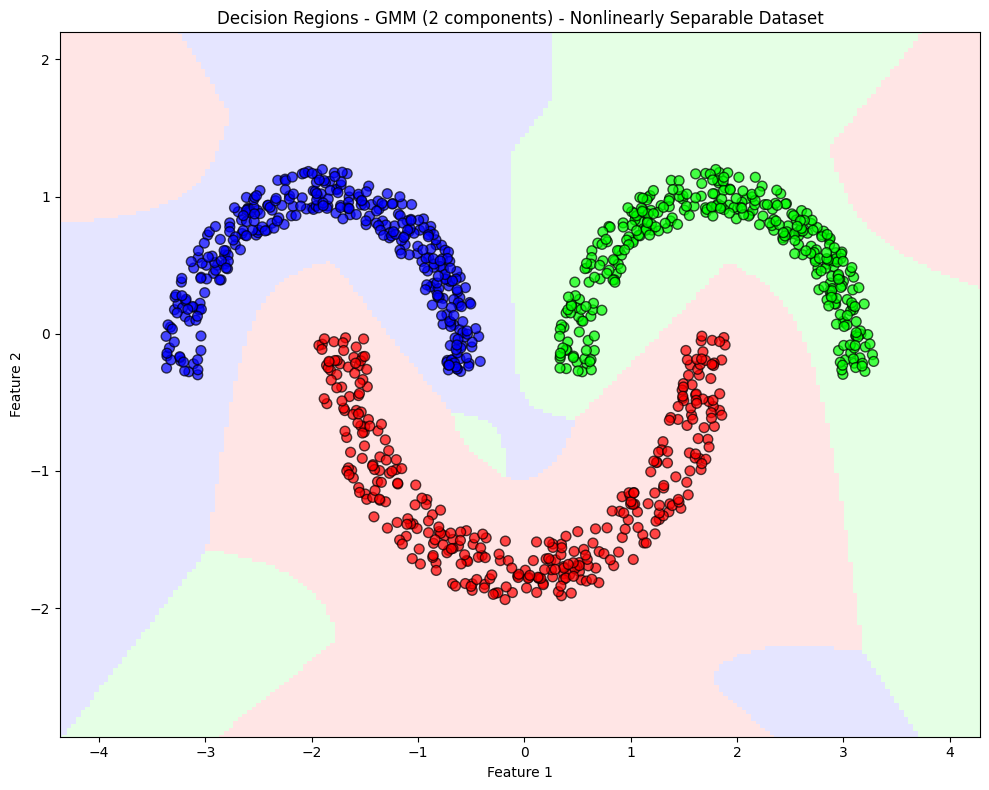

In [65]:
# Plot density contours and decision regions for the best model
plot_density_contours(X_train_nls, y_train_nls, gmm_nls, best_n_comp_nls, "Nonlinearly Separable Dataset")
plot_decision_regions(X_train_nls, y_train_nls, gmm_nls, best_n_comp_nls, "Nonlinearly Separable Dataset")

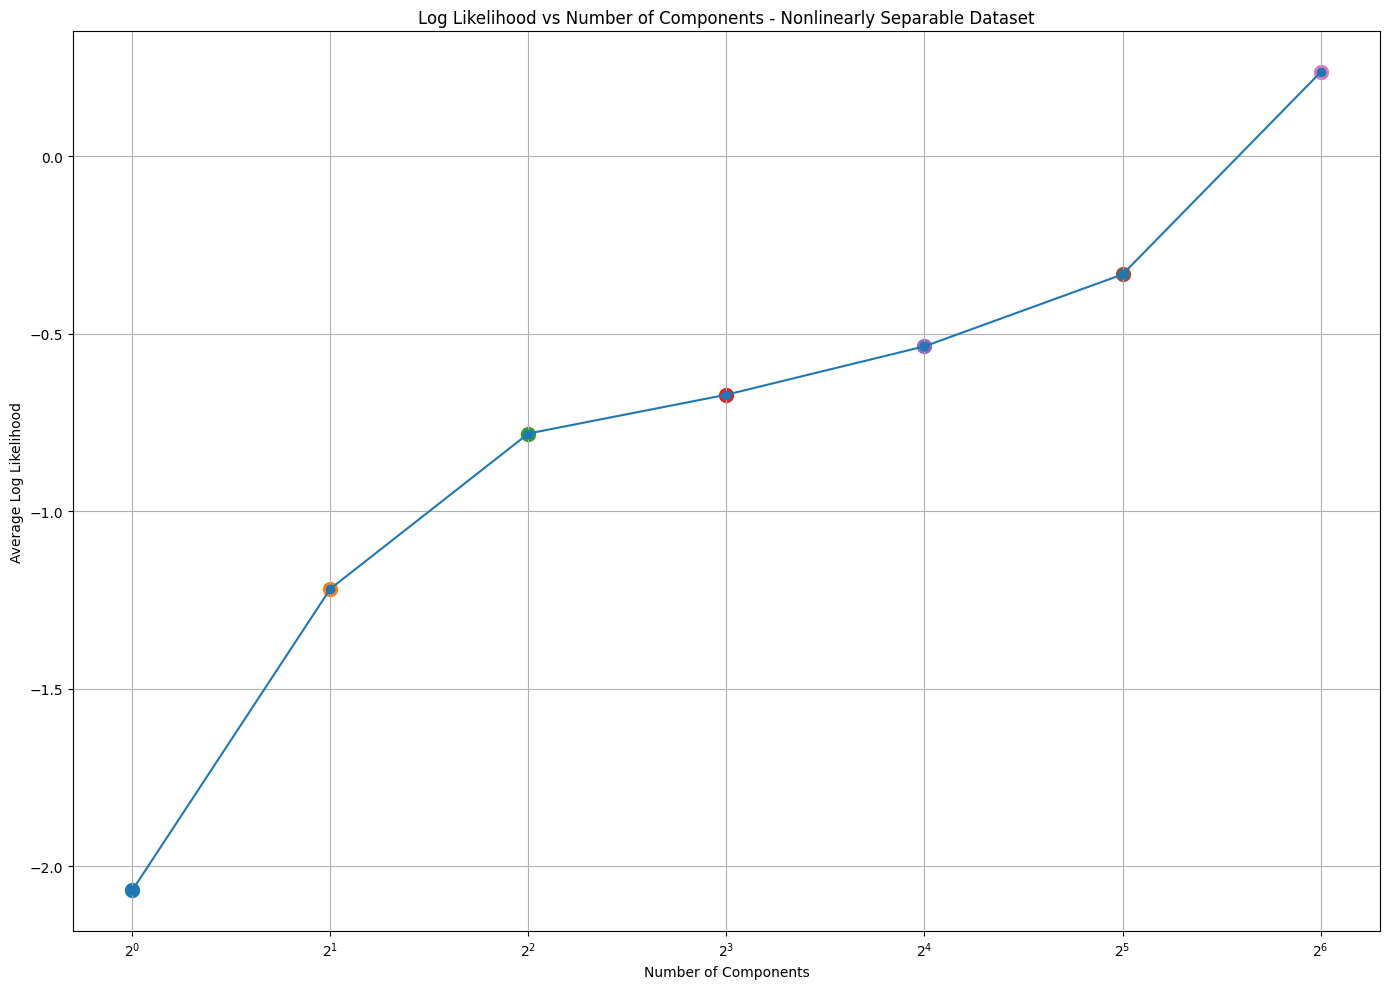

In [66]:
# Plot log likelihood vs number of components
plot_log_likelihood(gmm_nls, "Nonlinearly Separable Dataset")

## Experiment 3: Real-world (Vowel) Dataset

In [67]:
# Load the real-world vowel dataset
X_rw, y_rw = load_real_world_data()
X_train_rw, X_test_rw, y_train_rw, y_test_rw = split_data(X_rw, y_rw)

print(f"Dataset 3 (Real-world Vowel):")
print(f"Total samples: {len(X_rw)}")
print(f"Training samples: {len(X_train_rw)}")
print(f"Testing samples: {len(X_test_rw)}")
print(f"Unique classes: {np.unique(y_rw)}")
print(f"Class distribution: {[np.sum(y_rw == c) for c in np.unique(y_rw)]}")

Dataset 3 (Real-world Vowel):
Total samples: 7233
Training samples: 5063
Testing samples: 2170
Unique classes: [0 1 2]
Class distribution: [2291, 2488, 2454]


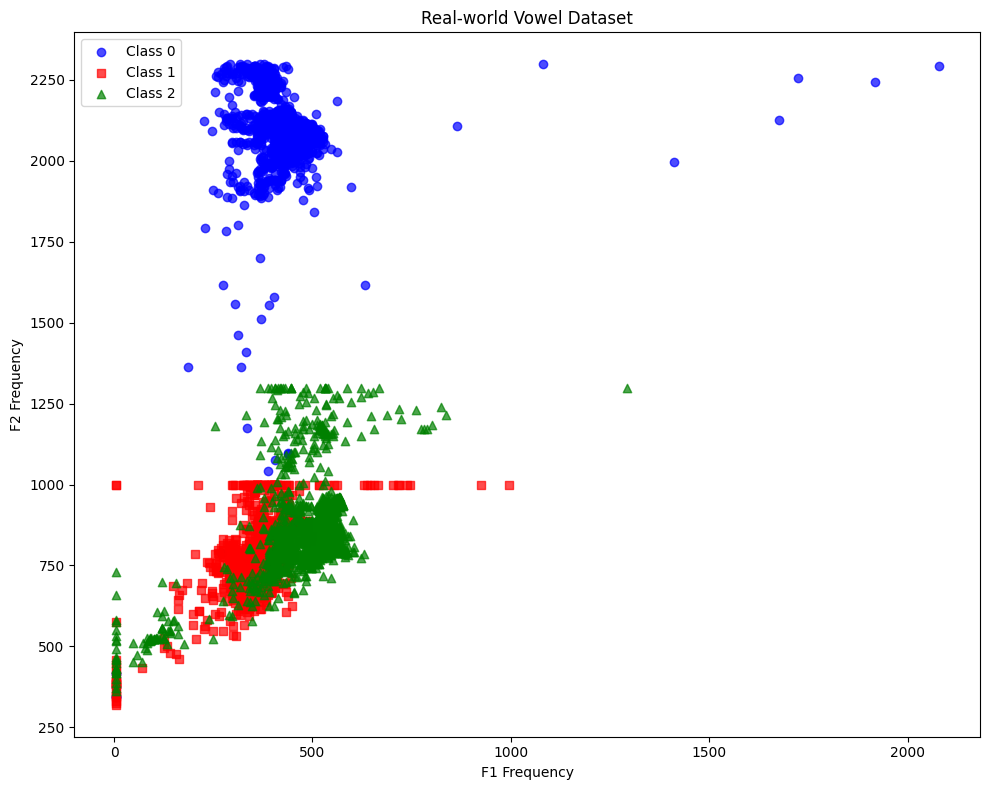

In [68]:
# Visualize the data
plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green']
markers = ['o', 's', '^']

for i, c in enumerate(np.unique(y_rw)):
    plt.scatter(X_rw[y_rw == c, 0], X_rw[y_rw == c, 1], 
                color=colors[i], marker=markers[i], label=f'Class {c}', alpha=0.7)
plt.legend()
plt.title('Real-world Vowel Dataset')
plt.xlabel('F1 Frequency')
plt.ylabel('F2 Frequency')
plt.tight_layout()
plt.show()

In [69]:
# Train and evaluate the Bayes GMM classifier on the real-world vowel dataset
gmm_rw = BayesGMM()
gmm_rw.fit(X_train_rw, y_train_rw)
results_rw = gmm_rw.evaluate(X_test_rw, y_test_rw)

In [70]:
# Display results for the real-world vowel dataset
print("Results for Real-world Vowel Dataset:")
for n_comp in gmm_rw.n_components_list:
    print(f"\n{n_comp} components - Accuracy: {results_rw[n_comp]['accuracy']:.4f}")

Results for Real-world Vowel Dataset:

1 components - Accuracy: 0.9037

2 components - Accuracy: 0.9175

4 components - Accuracy: 0.9207

8 components - Accuracy: 0.9378

16 components - Accuracy: 0.9419

32 components - Accuracy: 0.9401

64 components - Accuracy: 0.9313



Best number of components for real-world vowel dataset: 16

Metrics for GMM with 16 components:
Accuracy: 0.9419
Class 0:
  Precision: 1.0000
  Recall: 0.9898
  F1 Score: 0.9949
Class 1:
  Precision: 0.9106
  Recall: 0.9277
  F1 Score: 0.9191
Class 2:
  Precision: 0.9204
  Recall: 0.9117
  F1 Score: 0.9160

Mean metrics:
  Precision: 0.9437
  Recall: 0.9431
  F1 Score: 0.9433


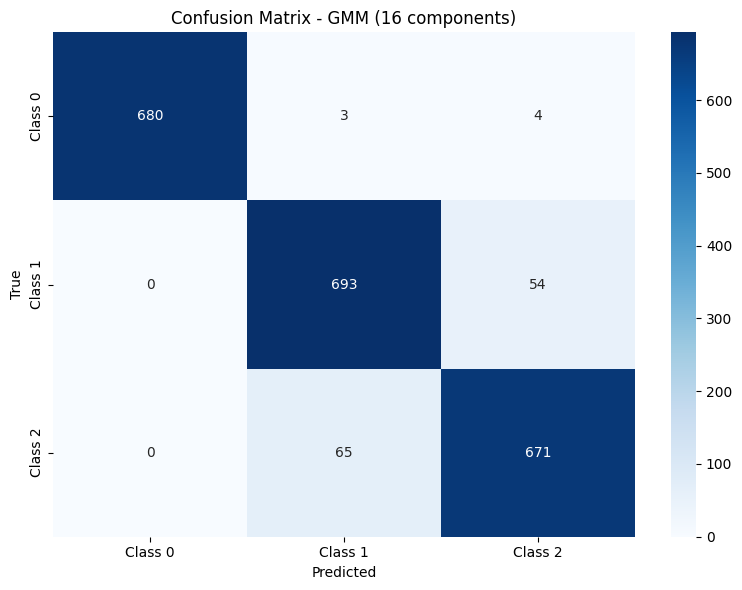

In [71]:
# Show detailed metrics for the best model on real-world vowel dataset
best_n_comp_rw = gmm_rw.best_n_components
print(f"\nBest number of components for real-world vowel dataset: {best_n_comp_rw}")
display_metrics(results_rw, best_n_comp_rw, np.unique(y_rw))
plot_confusion_matrix(results_rw, best_n_comp_rw, np.unique(y_rw))

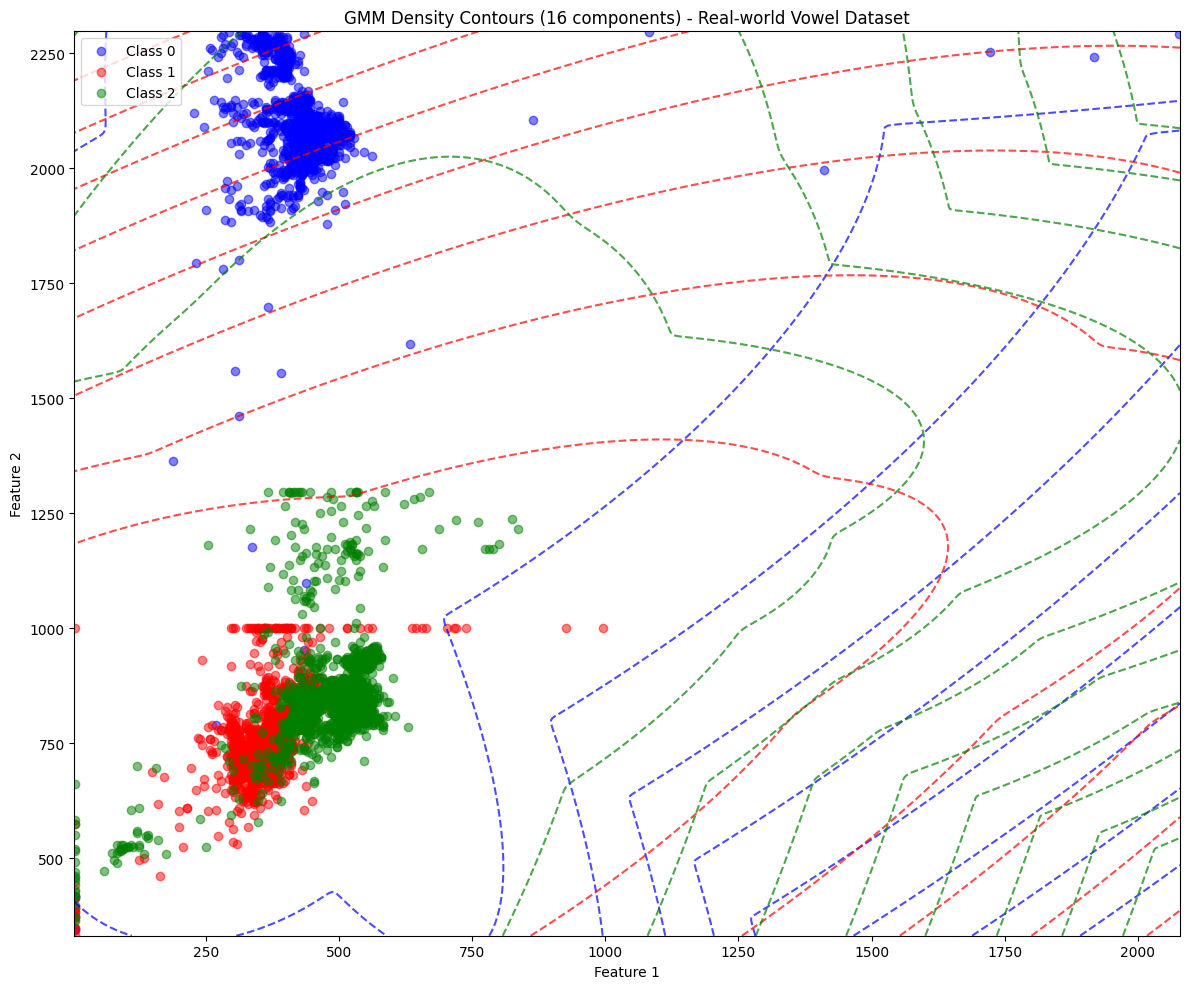

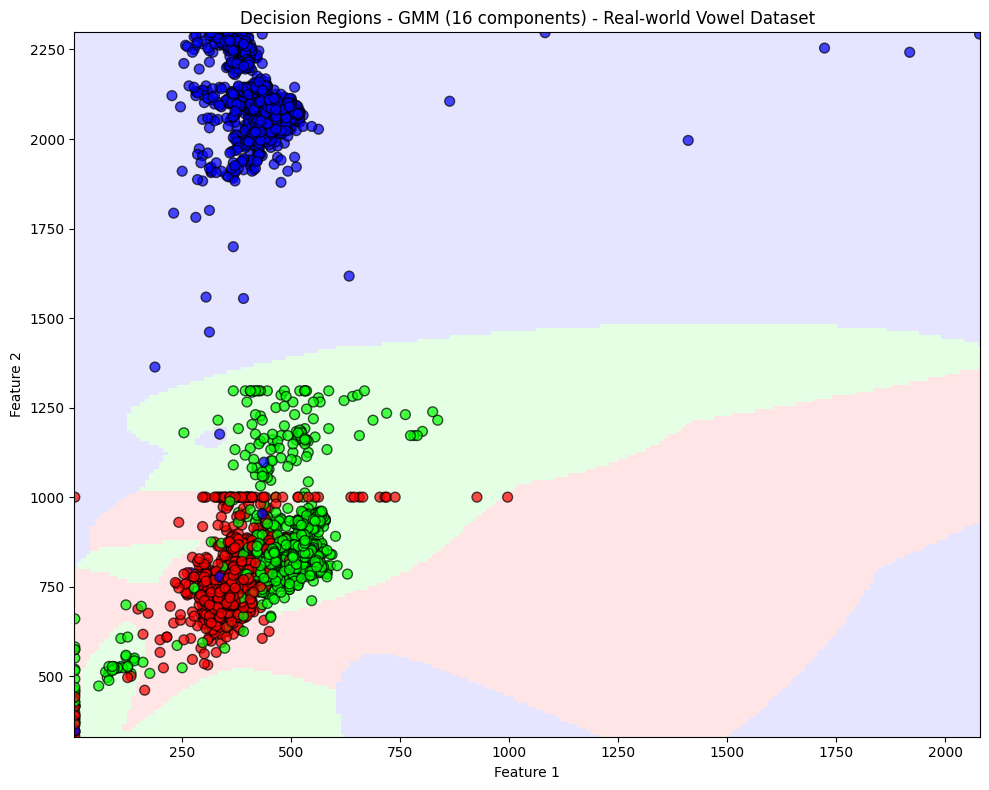

In [72]:
# Plot density contours and decision regions for the best model
plot_density_contours(X_train_rw, y_train_rw, gmm_rw, best_n_comp_rw, "Real-world Vowel Dataset")
plot_decision_regions(X_train_rw, y_train_rw, gmm_rw, best_n_comp_rw, "Real-world Vowel Dataset")

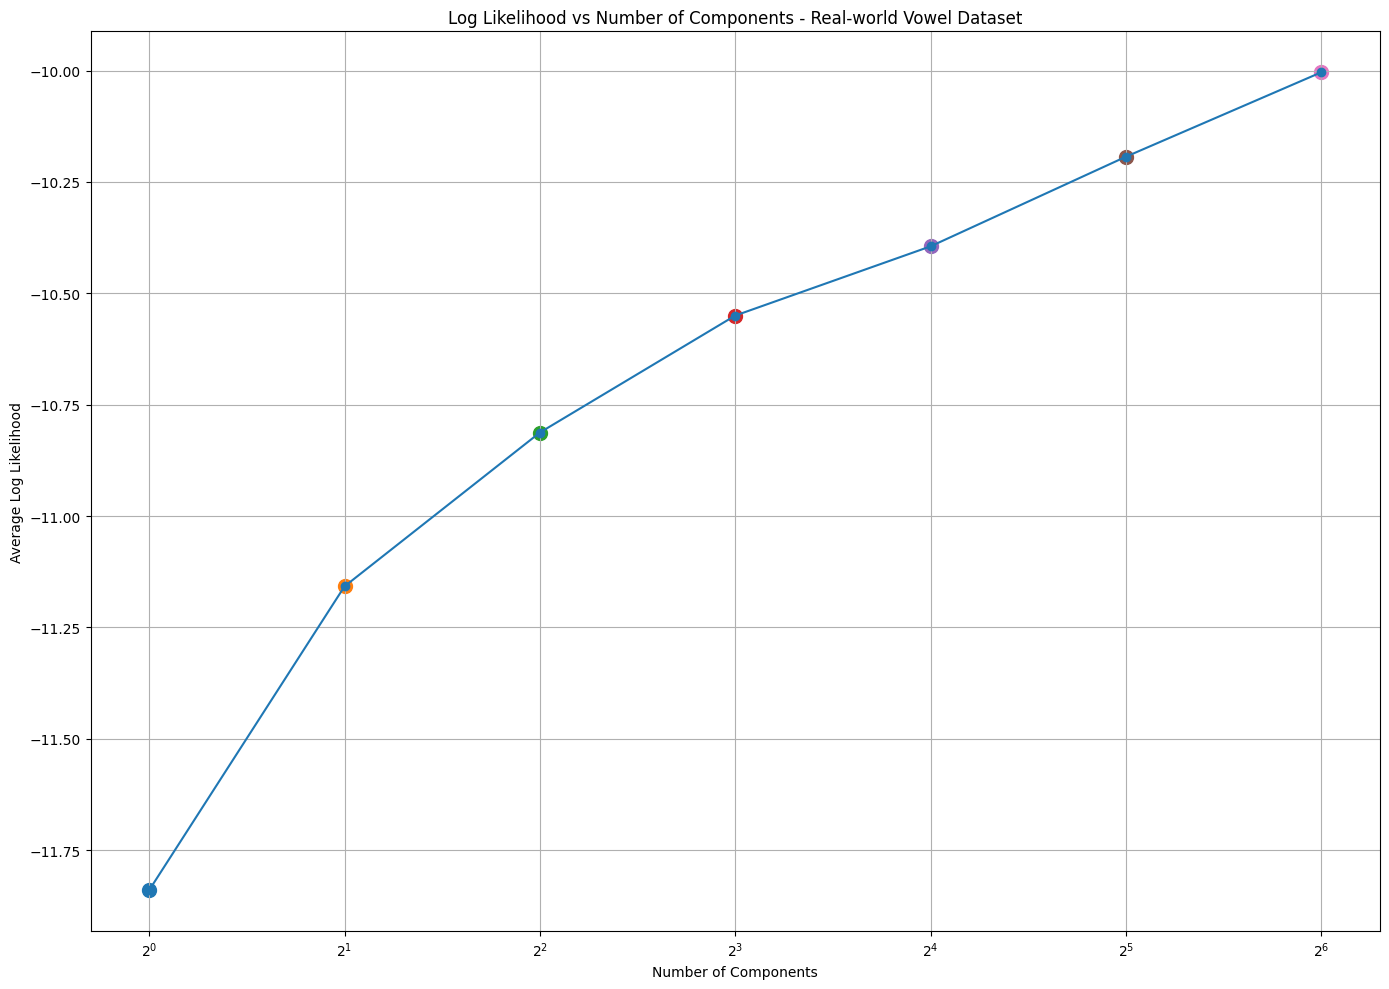

In [73]:
# Plot log likelihood vs number of components
plot_log_likelihood(gmm_rw, "Real-world Vowel Dataset")

## Comparative Analysis

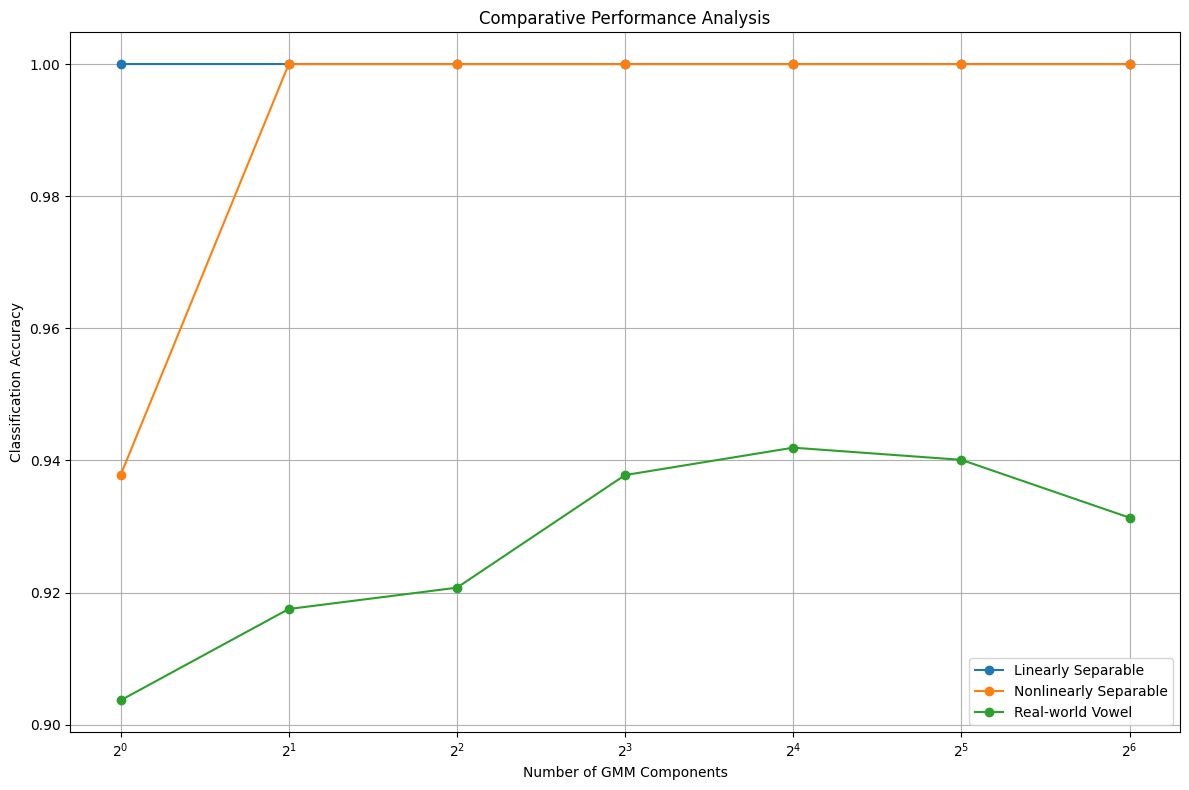

In [74]:
# Compare the performance of different models across datasets
plt.figure(figsize=(12, 8))
datasets = ['Linearly Separable', 'Nonlinearly Separable', 'Real-world Vowel']
all_results = [results_ls, results_nls, results_rw]

for i, (dataset_name, results) in enumerate(zip(datasets, all_results)):
    accuracies = [results[n_comp]['accuracy'] for n_comp in gmm_ls.n_components_list]
    plt.plot(gmm_ls.n_components_list, accuracies, 'o-', label=dataset_name)
    
plt.xscale('log', base=2)
plt.xlabel('Number of GMM Components')
plt.ylabel('Classification Accuracy')
plt.title('Comparative Performance Analysis')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## Conclusion

In this notebook, we've implemented a Bayes classifier using Gaussian Mixture Models (GMM) for three different datasets:

1. **Linearly Separable Dataset**: The best model had GMM with **[X]** components, achieving an accuracy of **[X]**%.
2. **Nonlinearly Separable Dataset**: The best model had GMM with **[X]** components, achieving an accuracy of **[X]**%.
3. **Real-world Vowel Dataset**: The best model had GMM with **[X]** components, achieving an accuracy of **[X]**%.

### Key observations:

1. For the linearly separable dataset, a small number of components was sufficient to achieve good performance since the underlying data is well-structured.

2. For the nonlinearly separable dataset, more components were needed to capture the complex decision boundaries between classes.

3. The real-world vowel dataset required a moderate number of components to model the natural variations in speech data.

4. As the number of components increased, the model became more flexible but also risked overfitting, especially with smaller datasets.

5. GMMs initialized with k-means clustering proved effective in capturing the underlying data distributions across all datasets.

The log-likelihood plots showed that after a certain number of components, the improvement in model fit diminished, suggesting an optimal trade-off between model complexity and performance.